In [1]:
#imports
from pybaseball import statcast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Can a ML Model Learn the Strike Zone?
In Baseball, the Strike Zone is the space which a pitch must pass in order to be called a strike even if the batter does not swing. If the pitch ends up outside of this area and the batter does not swing, then the pitch is declared a ball. While the batter can still recieve a strike if he swings at a ball thrown outside of the strike zone, on the agregate most batters will not swing at these pitchs and thus recieve a ball.

---

In our data set pitches are recorded as strikes (s), in plays (x), and balls (b). We will predict the pitch outcome by the location relative to the plate. The reason we will be training our model to detect just balls (rather than just strikes and in plays) is because the majority of in plays and strikes are in the strike zone (so we can not differentiate them based solely on location, while all balls are outside of it). Thus if we can train our model to detect balls, we have determined the strike zone.

---
First let us clean the data. We will read in and explore our data.

In [2]:
data = statcast('2025-03-30', '2025-04-15')

This is a large query, it may take a moment to complete


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:08<00:00,  2.00it/s]


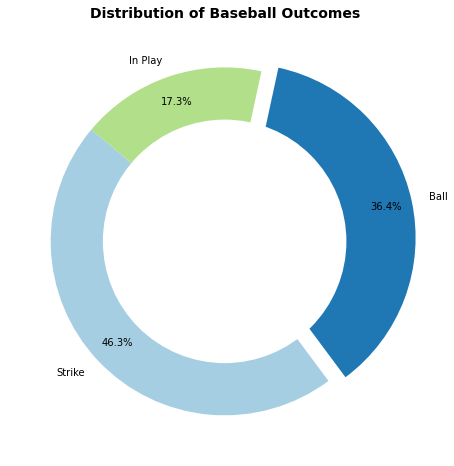

In [3]:
# Load a Seaborn color palette
colors = sns.color_palette("Paired", 3)

# Data
labels = ['Strike', 'Ball', 'In Play']
sizes = [data.type.value_counts().S, data.type.value_counts().B, data.type.value_counts().X]
explode = (0, .1, 0)  
# Style adjustments
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors, explode=explode,
        autopct='%1.1f%%', pctdistance=0.85, startangle=140)

# Create a donut-style chart
centre_circle = plt.Circle((0,0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)

# Improve aesthetics
plt.title('Distribution of Baseball Outcomes', fontsize=14, fontweight='bold')
plt.gca().set_facecolor('#f7f7f7')  # Set background color

plt.show()

It looks like most pitches thrown so far this season have been strikes, followed by balls, and then in plays. These numbers make intuitive sense with what one sees when they watch a baseball game. This also gives us a benchmark for predicting balls. Our baseline accuracy is 63.5% (the probability of randomly picking a ball), so if our model performs better than that, it will have learnt the strike zone.

In [4]:
data["isBall"] = data.type == "B"

In [5]:
data2 = data.dropna(subset=['plate_x', 'plate_z', 'isBall'])


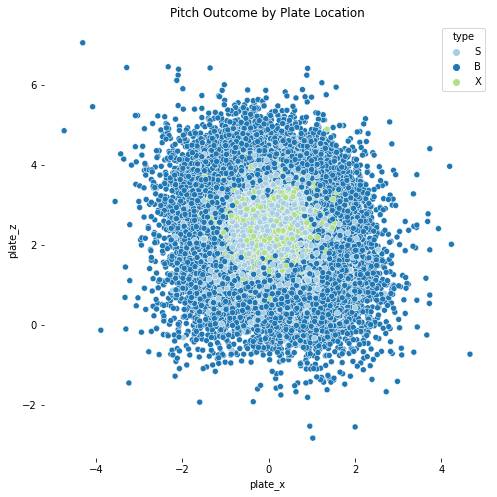

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.despine(fig, left=True, bottom=True)
sns.scatterplot(x="plate_x", y="plate_z",
                hue="type", 
                palette='Paired', 
                data=data2, ax=ax)
ax.set_title("Pitch Outcome by Plate Location")
plt.show()

Here we can see that most of the strikes and inplays occur within the same area towards the center of the graph. On the other hands, the balls are around the perimeter of this strike zone. Thus we should be able to detect the balls with K-Nearest Neighbors

---
# KNN
The way that K-Nearest Neighbors works is by initializing a value of k. Then for any data point you want to calculate, you find the k points in the training set that are closest to it and figure out what is the most common label amongst those training points. The simplest case of the algorithm is to use an odd k that way there is always a clear majority. The algorithm can also be used for regression (taking the mean of the nearest labels' values), but that is outside the scope of this project.

---
To start we will implent the Euclidean distance. Because of samples are in two dimensional space, we can use
$$d(p,q)=\sqrt{(p_x-q_x)^2+(p_y-q_y)^2}=||p-q||$$

In [7]:
def distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

Now we will include two more functions onto our class
### k_nearest_neighbors
This function will take in a point
neugbors as a priority queue. Store onto neighbors the its label with a priority of d. Then at the end it
takes out the k smallest priorites (ie distances) and returns those labels. Thus we get the labels of the closest points.

### Predict
Take the point we are predicting, find its k nearest neighbors, iterate over the unique labels set of labels, and then return the maximally occur label.

In [8]:
import heapq

class KNN:
    def __init__(self, k: int):
        self.k = k
    
    def train(self, training_features: list, training_labels: list):
        self.training_features = training_features
        self.training_labels = training_labels
    
    def k_nearest_neighbors(self, point: list):
        neighbors = []

        for p, label in zip(self.training_features, self.training_labels):
            d = distance(point, p)
            heapq.heappush(neighbors, (d, label))
        
        return heapq.nsmallest(self.k, neighbors)

    def predict(self, point: list):
        neighbors = self.k_nearest_neighbors(point)
        labels = [label for _, label in neighbors]
        return max(set(labels), key=labels.count)

In [9]:
from sklearn.model_selection import train_test_split

X = data2[["plate_x","plate_z"]].iloc[:1000]
y = (data2["type"] == "B").iloc[:1000]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### KFoldCV
To determine the optimal number of neighbors we want to consider, we will use K-Folds Cross Validation. The algorithm works by splitting the data into $k$ folds. For example, let's say $k=3$. So we split our training data into thirds, and iterate through these thirds, selecting two for training and one for validation, and average out the accuracy. The purpose of this is that we can run this algorithm on our model with a different number of neighbors selected in order to determine the optimal number of neighbors to consider.

In [10]:

class KFoldCV:
    def __init__(self, k: int):
        self.k = k
    
    def split(self, X, y):
        """ Splits the dataset into k folds """
        indices = np.arange(len(X))
        np.random.shuffle(indices)  # Shuffle to ensure randomness
        folds = np.array_split(indices, self.k)
        return folds
    
    def evaluate(self, model, X, y):
        """ Performs k-fold cross-validation """
        folds = self.split(X, y)
        scores = []
        
        for i in range(self.k):
            #Combine segments to create folds
            train_idx = np.concatenate([folds[j] for j in range(self.k) if j != i])
            test_idx = folds[i]

            #Getting training and test data
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]

            #test model and compute accuraucy
            model.train(X_train, y_train)
            predictions = [model.predict(x) for x in X_test]
            accuracy = np.mean(np.array(predictions) == y_test)

            scores.append(accuracy)
        
        return np.mean(scores) #mean of all evaluations

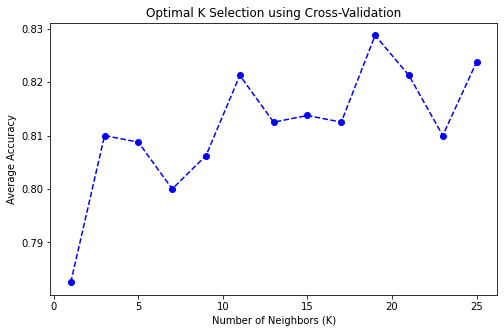

Optimal K: 19, Accuracy: 0.83


In [11]:
# Initialize K-Folds Cross-Validation
kf = KFoldCV(5)

# Test different K values
k_range = range(1, 26, 2)  # Testing K from 1 to 20
mean_accuracy = []

for k in k_range:
    model = KNN(k)
    acc = kf.evaluate(model, X_train.to_numpy(), y_train.to_numpy())
    mean_accuracy.append(acc)
# Plot K vs. Accuracy
plt.figure(figsize=(8, 5))
plt.plot(k_range, mean_accuracy, marker='o', linestyle='dashed', color='b')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Average Accuracy')
plt.title('Optimal K Selection using Cross-Validation')
plt.show()

# Print the best K value
optimal_k = k_range[np.argmax(mean_accuracy)]
print(f'Optimal K: {optimal_k}, Accuracy: {max(mean_accuracy):.2f}')

In [13]:
print("Training Size:", X_train.shape)

Training Size: (800, 2)


The optimal $k=19$. This makes sense as we have 800 training points. Also, this should be enough points that if we have the strikes outside the strike zone should not have much influence on classifying balls.

In [14]:
knn = KNN(19)

knn.train(X_train.to_numpy(), y_train.to_numpy())

y_pred = [knn.predict(pt) for pt in X_test.to_numpy()]

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.85      0.91      0.88       132
        True       0.79      0.68      0.73        68

    accuracy                           0.83       200
   macro avg       0.82      0.79      0.80       200
weighted avg       0.83      0.83      0.83       200



Looking at a larger training set evaluate our model with $k=19$.
* Accuracy: our model correctly identifies pitches 83% of the time 
* Precision: when the model predicts a ball it is correct 79% of the time. When it predicts not a ball it is correct 85% of the time
* Recall: the model correctly identifies non-balls 91% of the time. It correctly identifies balls 68% of the time.


---
# Takeaways
While not perfect, our model is signficiantly more accurate than the 63.5% baseline of non-balls. Using K-Nearest Neighbors works well in this situation because we are able to consider pitches that end up near where our target pitch lands and from there classify it. While a batter might swing at a pitch outside the strike zone, $k=19$ seems to effectively consider enough points for the aggregate trend. The reason for the low recall for balls (.68) is if a pitch (that should be a ball) is near the strike zone, it will be classified as a strike. This large $k$ value does have its benefits though: balls thrown outside the strike zone will not be influenced by swinging strikes near them in the training set. Overall, when not considering for the complexities of plate discipline (a batter's ability to not swing at a pitch thrown outside the strike zone) and the fact that the strike zone can vary slightly based on a player's height, our model is very accurate.